# GENESIS Python Interface Hands-on Tutorial

This tutorial will guide you through using the Python interface for the analysis tools of GENESIS (Generalized Ensemble Simulation System). This interface allows you to easily use th analysis tools from Python scripts, integrate with other Python libraries, and visualize the results.

**This tutorial covers:**

1.  **Introduction**: Overview and setup.
2.  **Loading Molecular Information**: The `SMolecule` class and visualization with `py3Dmol`.
3.  **Loading & Visualizing Trajectory Data**: `crd_convert` and `py3Dmol`.
4.  **Basic Trajectory Analysis & Plotting**:
    * Distance, angle, and dihedral analysis (`trj_analysis`) with `plotly`.
    * Radius of gyration (`rg_analysis`) with `plotly`.
    * RMSD (`rmsd_analysis`) with `plotly`.
    * dRMSD (`drms_analysis`) with `plotly`.
    * Average structure (`avecrd_analysis`) with `py3Dmol`.
5.  **Advanced Analysis & Plotting**:
    * Mean square displacement and diffusion coefficient (`msd_analysis`, `diffusion_analysis`) with `plotly`.
6.  **Interfacing with External MD Libraries**: MDTraj and MDAnalysis.
7.  **Interfacing with Scikit-learn**: Feature preparation, t-SNE (dimensionality reduction), and DBSCAN (clustering) with `plotly`.
8.  **Interfacing with PyTorch**: Data preparation and a conformational autoencoder example with `plotly`.
9.  **Conclusion**

**Prerequisites**:

* GENESIS (with the Python interface correctly compiled and installed).
* Python 3.x
* NumPy (`pip install numpy`)
* Plotly (`pip install plotly`)
* py3Dmol (`pip install py3Dmol`)
* (Optional but Recommended for Section 6 & py3Dmol data prep) MDTraj (`pip install mdtraj`)
* (Optional but Recommended for Section 6) MDAnalysis (`pip install mdanalysis`)
* (Required for Section 7) Scikit-learn (`pip install scikit-learn`)
* (Required for Section 8) PyTorch (`pip install torch`)
* Jupyter Notebook or JupyterLab environment (highly recommended for running code blocks, especially `py3Dmol` and `plotly`).


**Input Files**:
This tutorial assumes you have the following files in your working directory:
* `BPTI_ionize.pdb`: A PDB file of your system (e.g., the initial structure for BPTI example).
* `BPTI_ionize.psf`: A PSF file corresponding to your PDB.
* `BPTI_run.dcd`: A DCD trajectory file from a GENESIS simulation of BPTI.


## 1. Introduction

The GENESIS Python interface bridges GENESIS's C/Fortran analysis routines with Python's scripting power. It simplifies workflows and enables integration with Python's scientific ecosystem.

Key components:
* `ctypes` wrappers (`libgenesis.py`, `s_molecule_c.py`, `s_trajectories_c.py`).
* Data converters (`py2c_util.py`, `c2py_util.py`).
* Pythonic classes (`SMolecule`, `STrajectories`).
* High-level analysis functions (`genesis_exe.py`).
* Control file utilities (`ctrl_files.py`).

Let's import modules. Ensure the GENESIS Python interface (`genesis_interface`) is in your `PYTHONPATH`.


In [1]:
import os
import pathlib
import numpy as np
import warnings

# Plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import py3Dmol # For Jupyter environment

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# GENESIS Python interface modules
from genepy import SMolecule, STrajectories, STrajectoriesArray, genesis_exe, LibGenesis, ctrl_files
print("GENESIS Python interface modules imported successfully.")

# Define file paths (assuming they are in the current directory)
PDB_PATH = pathlib.Path("chignolin.pdb")
PSF_PATH = pathlib.Path("chignolin.psf")
DCD_PATH = pathlib.Path("chignolin.dcd")

GENESIS Python interface modules imported successfully.


## 2. Loading Molecular Information: `SMolecule` Class

The SMolecule class stores static molecular data (topology, atom properties). It's loaded from files like PDB and PSF.

In [2]:
# Load molecular information
mol_allatom = SMolecule.from_file(pdb=PDB_PATH, psf=PSF_PATH)
print(f"Molecular information loaded from {PDB_PATH} and {PSF_PATH}.")
print(f"Number of atoms: {mol_allatom.num_atoms}")
print(f"First atom name: {''.join(mol_allatom.atom_name[0])}")
print(f"First atom coordinates: {mol_allatom.atom_coord[0]}")

arg[0] pdb: c_char_p(4378498768), type = <class 'ctypes.c_char_p'>
arg[1] top: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[2] gpr: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[3] psf: c_char_p(4378498816), type = <class 'ctypes.c_char_p'>
arg[4] ref: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[5] fit: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[6] prmtop: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[7] ambcrd: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[8] ambref: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[9] grotop: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[10] grocrd: c_char_p(None), type = <class 'ctypes.c_char_p'>
arg[11] groref: c_char_p(None), type = <class 'ctypes.c_char_p'>
define_molecule_from_file retturned: 0
Molecular information loaded from chignolin.pdb and chignolin.psf.
Number of atoms: 138
First atom name: N   
First atom coordinates: [-4.307  5.199  2.726]


In [3]:
# subset_atoms(self, atom_indices: npt.NDArray[np.int64]) -> Self:
mol_selected = mol_allatom.subset_atoms(np.array([1, 2, 3]))

print(f"Molecular information loaded from {PDB_PATH} and {PSF_PATH}.")
print(f"Number of atoms: {mol_selected.num_atoms}")
print(f"First atom name: {''.join(mol_selected.atom_name[0])}")
print(f"First atom coordinates: {mol_selected.atom_coord[0]}")

Molecular information loaded from chignolin.pdb and chignolin.psf.
Number of atoms: 3
First atom name: HT1 
First atom coordinates: [-4.859  6.029  3.023]


## 3. Loading & Visualizing Trajectory Data: `STrajectories` Class

MD trajectory data (STrajectories objects) are typically loaded and processed using the crd_convert tool.

In [4]:
# Define trajectory parameters for all examples
traj_params_list = [
    ctrl_files.TrajectoryParameters(
        trjfile=str(DCD_PATH), 
        md_step=2200, mdout_period=1, ana_period=1, repeat=1
    )
]
print(f"Trajectory parameters defined for: {DCD_PATH}")


Trajectory parameters defined for: chignolin.dcd


## 3.1. Atom Selection Examples with crd_convert

The `crd_convert` function now returns both trajectory data and a subset molecule object. Here are various atom selection patterns you can use:


In [5]:
# Example 1: Load trajectory with CA atom selection
print("=== Example 1: CA atom selection ===")
trajs_array_ca, mol_ca_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["an:CA"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
#traj_ca = trajs_array_ca[0]
#print(f"CA trajectory: {traj_ca.nframe} frames, {traj_ca.natom} atoms")
#print(f"CA subset molecule: {mol_ca_subset.num_atoms} atoms")
#print(f"CA subset matches trajectory: {mol_ca_subset.num_atoms == traj_ca.natom}")

# Verify CA atoms
#ca_atom_names = [''.join(name_array).strip() for name_array in mol_ca_subset.atom_name]
#print(f"CA atom names: {ca_atom_names[:5]}...")
#print(f"All atoms are CA: {all(name == 'CA' for name in ca_atom_names)}")


=== Example 1: CA atom selection ===


In [6]:
# Example 2: Load trajectory with all atoms selection
print("=== Example 2: All atoms selection ===")
trajs_array_all, mol_all_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["all"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
traj_all = trajs_array_all[0]
print(f"All trajectory: {traj_all.nframe} frames, {traj_all.natom} atoms")
print(f"All subset molecule: {mol_all_subset.num_atoms} atoms")
print(f"All subset matches trajectory: {mol_all_subset.num_atoms == traj_all.natom}")
print(f"All subset matches original: {mol_all_subset.num_atoms == mol_allatom.num_atoms}")
print(f"All subset is copy: {mol_all_subset is not mol_allatom}")


=== Example 2: All atoms selection ===
All trajectory: 2200 frames, 138 atoms
All subset molecule: 138 atoms
All subset matches trajectory: True
All subset matches original: True
All subset is copy: True


In [7]:
# Example 3: Load trajectory without selection (defaults to all atoms)
print("=== Example 3: Default selection (no selection_group specified) ===")
trajs_array_default, mol_default_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    # No selection_group specified - defaults to ["all"]
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
traj_default = trajs_array_default[0]
print(f"Default trajectory: {traj_default.nframe} frames, {traj_default.natom} atoms")
print(f"Default subset molecule: {mol_default_subset.num_atoms} atoms")
print(f"Default subset matches trajectory: {mol_default_subset.num_atoms == traj_default.natom}")
print(f"Default subset matches original: {mol_default_subset.num_atoms == mol_allatom.num_atoms}")
print(f"Default subset is copy: {mol_default_subset is not mol_allatom}")


=== Example 3: Default selection (no selection_group specified) ===
Default trajectory: 2200 frames, 138 atoms
Default subset molecule: 138 atoms
Default subset matches trajectory: True
Default subset matches original: True
Default subset is copy: True


In [8]:
# Example 4: Multiple atom types selection
print("=== Example 4: Multiple atom types selection (CA + CB) ===")
trajs_array_multi, mol_multi_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["an:CA or an:CB"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
traj_multi = trajs_array_multi[0]
print(f"Multi trajectory: {traj_multi.nframe} frames, {traj_multi.natom} atoms")
print(f"Multi subset molecule: {mol_multi_subset.num_atoms} atoms")
print(f"Multi subset matches trajectory: {mol_multi_subset.num_atoms == traj_multi.natom}")

# Verify multi selection
multi_atom_names = [''.join(name_array).strip() for name_array in mol_multi_subset.atom_name]
ca_count = sum(1 for name in multi_atom_names if name == 'CA')
cb_count = sum(1 for name in multi_atom_names if name == 'CB')
print(f"CA atoms: {ca_count}, CB atoms: {cb_count}")
print(f"Total selected atoms: {ca_count + cb_count}")
print(f"Multi atom names (first 10): {multi_atom_names[:10]}")


=== Example 4: Multiple atom types selection (CA + CB) ===
Multi trajectory: 2200 frames, 17 atoms
Multi subset molecule: 17 atoms
Multi subset matches trajectory: True
CA atoms: 10, CB atoms: 7
Total selected atoms: 17
Multi atom names (first 10): ['CA', 'CA', 'CB', 'CA', 'CB', 'CA', 'CB', 'CA', 'CB', 'CA']


In [9]:
# Example 5: Heavy atoms selection
print("=== Example 5: Heavy atoms selection ===")
trajs_array_heavy, mol_heavy_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["heavy"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
traj_heavy = trajs_array_heavy[0]
print(f"Heavy trajectory: {traj_heavy.nframe} frames, {traj_heavy.natom} atoms")
print(f"Heavy subset molecule: {mol_heavy_subset.num_atoms} atoms")
print(f"Heavy subset matches trajectory: {mol_heavy_subset.num_atoms == traj_heavy.natom}")

# Verify heavy atoms (no hydrogen atoms)
heavy_atom_names = [''.join(name_array).strip() for name_array in mol_heavy_subset.atom_name]
h_count = sum(1 for name in heavy_atom_names if name.startswith('H'))
print(f"Hydrogen atoms in heavy selection: {h_count}")
print(f"Heavy atom names (first 10): {heavy_atom_names[:10]}")


=== Example 5: Heavy atoms selection ===
Heavy trajectory: 2200 frames, 77 atoms
Heavy subset molecule: 77 atoms
Heavy subset matches trajectory: True
Hydrogen atoms in heavy selection: 0
Heavy atom names (first 10): ['N', 'CA', 'C', 'O', 'N', 'CA', 'CB', 'CG', 'CD1', 'CE1']


In [10]:
# Example 6: Residue-based selection
print("=== Example 6: Residue-based selection (first 3 residues) ===")
trajs_array_res, mol_res_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["rno:1-3"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
traj_res = trajs_array_res[0]
print(f"Residue trajectory: {traj_res.nframe} frames, {traj_res.natom} atoms")
print(f"Residue subset molecule: {mol_res_subset.num_atoms} atoms")
print(f"Residue subset matches trajectory: {mol_res_subset.num_atoms == traj_res.natom}")

# Verify residue selection
residue_names = [str(name).strip() for name in mol_res_subset.residue_name]
unique_residues = list(set(residue_names))
print(f"Unique residues in selection: {unique_residues}")
print(f"Residue names (first 10): {residue_names[:10]}")


=== Example 6: Residue-based selection (first 3 residues) ===
Residue trajectory: 2200 frames, 42 atoms
Residue subset molecule: 42 atoms
Residue subset matches trajectory: True
Unique residues in selection: ['GLY', 'TYR', 'ASP']
Residue names (first 10): ['GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'GLY', 'TYR']


In [11]:
# Example 7: Complex selection with multiple criteria
print("=== Example 7: Complex selection (CA atoms of first 5 residues) ===")
trajs_array_complex, mol_complex_subset = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["rno:1-5 and an:CA"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
traj_complex = trajs_array_complex[0]
print(f"Complex trajectory: {traj_complex.nframe} frames, {traj_complex.natom} atoms")
print(f"Complex subset molecule: {mol_complex_subset.num_atoms} atoms")
print(f"Complex subset matches trajectory: {mol_complex_subset.num_atoms == traj_complex.natom}")

# Verify complex selection
complex_atom_names = [''.join(name_array).strip() for name_array in mol_complex_subset.atom_name]
complex_residue_names = [str(name).strip() for name in mol_complex_subset.residue_name]
print(f"Complex atom names: {complex_atom_names}")
print(f"Complex residue names: {complex_residue_names}")
print(f"All atoms are CA: {all(name == 'CA' for name in complex_atom_names)}")
print(f"Number of unique residues: {len(set(complex_residue_names))}")


=== Example 7: Complex selection (CA atoms of first 5 residues) ===
Complex trajectory: 2200 frames, 5 atoms
Complex subset molecule: 5 atoms
Complex subset matches trajectory: True
Complex atom names: ['CA', 'CA', 'CA', 'CA', 'CA']
Complex residue names: ['GLY', 'TYR', 'ASP', 'PRO', 'GLU']
All atoms are CA: True
Number of unique residues: 5


### Summary of Atom Selection Patterns

The `crd_convert` function now returns a tuple `(STrajectoriesArray, SMolecule)` where:

- **STrajectoriesArray**: Contains trajectory data (coordinates, frames, etc.)
- **SMolecule**: A subset molecule containing only the selected atoms

**Key Features:**
- All cases return a **copy** of the molecule (never the original)
- When no `selection_group` is specified, it defaults to `["all"]`
- The subset molecule always matches the trajectory atom count for the selected atoms
- You can use various selection patterns:

| Selection Pattern | Description | Example |
|------------------|-------------|---------|
| `["an:CA"]` | Alpha carbon atoms | `selection_group=["an:CA"]` |
| `["all"]` | All atoms | `selection_group=["all"]` |
| `["heavy"]` | Heavy atoms (no hydrogens) | `selection_group=["heavy"]` |
| `["an:CA or an:CB"]` | Multiple atom types | `selection_group=["an:CA or an:CB"]` |
| `["rno:1-5"]` | Residue range | `selection_group=["rno:1-5"]` |
| `["rno:1-5 and an:CA"]` | Complex selection | `selection_group=["rno:1-5 and an:CA"]` |
| `None` (default) | All atoms (default behavior) | No `selection_group` parameter |

**Usage:**
```python
# New interface - returns tuple
trajs_array, mol_subset = genesis_exe.crd_convert(
    molecule=mol, 
    traj_params=traj_params_list, 
    trj_format="DCD+BOX",
    trj_type="COOR", 
    selection_group=["an:CA"],  # or None for default
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)
```


## 3.2. Loading & Visualizing Trajectory Data: `STrajectories` Class

Now let's load trajectory data using the updated `crd_convert` function:


In [12]:
# Define trajectory parameters
traj_params_list = [
    ctrl_files.TrajectoryParameters(
        trjfile=str(DCD_PATH), 
        md_step=2200, mdout_period=1, ana_period=1, repeat=1
    )
]

print(f"Load trajectory using crd_convert from: {DCD_PATH}")
print("Selecting PROA segment (protein atoms only)...")

trajs_array, mol = genesis_exe.crd_convert(
    molecule=mol_allatom, 
    traj_params=traj_params_list, 
    trj_format="DCD",
    trj_type="COOR+BOX", 
    selection_group=["segid:PROA"], 
    fitting_method="TR+ROT", 
    fitting_atom=1, 
    pbc_correct="NO"
)

Load trajectory using crd_convert from: chignolin.dcd
Selecting PROA segment (protein atoms only)...


In [13]:
traj = trajs_array[0]
print(f"Trajectory loaded successfully via crd_convert.")
print(f"Frames: {traj.nframe}, Atoms: {traj.natom}")
print(f"Coordinates of 1st atom, 1st frame: {traj.coords[0, 0, :]}")
print(f"Original molecule atoms: {mol_allatom.num_atoms}")
print(f"Subset molecule atoms (PROA only): {mol.num_atoms}")
print(f"Subset molecule matches trajectory atoms: {mol.num_atoms == traj.natom}")
print(f"Subset molecule is copy: {mol is not mol_allatom}")

# Verify that we have PROA atoms only
if mol.num_atoms > 0:
    # Check segment IDs in the subset
    unique_segments = set()
    for i in range(mol.num_atoms):
        segid = ''.join(mol.segment_name[i]).strip()
        unique_segments.add(segid)
    print(f"Unique segments in subset: {unique_segments}")
    
    # Check if all atoms are from PROA
    all_proa = all(''.join(mol.segment_name[i]).strip() == 'PROA' for i in range(mol.num_atoms))
    print(f"All atoms are from PROA segment: {all_proa}")
    
    # Note: The trajectory still contains all atoms, but the subset molecule contains only PROA atoms
    # If you want trajectory coordinates for PROA atoms only, you need to filter them
    if traj.natom != mol.num_atoms:
        print(f"Note: Trajectory contains {traj.natom} atoms (all atoms), but subset molecule contains {mol.num_atoms} atoms (PROA only)")
        print("To get PROA-only trajectory coordinates, you would need to filter the trajectory data.")
        
        # Example: Get PROA atom indices from original molecule
        proa_indices = []
        for i in range(mol_allatom.num_atoms):
            segid = ''.join(mol_allatom.segment_name[i]).strip()
            if segid == 'PROA':
                proa_indices.append(i)
        
        # Filter trajectory coordinates to PROA atoms only
        traj_proa_coords = traj.coords[:, proa_indices, :]
        print(f"Filtered trajectory coordinates shape: {traj_proa_coords.shape}")
        print(f"PROA trajectory coordinates match subset molecule: {traj_proa_coords.shape[1] == mol.num_atoms}")
else:
    print("Warning: No atoms selected! Check if segid:PROA exists in your data.")

Trajectory loaded successfully via crd_convert.
Frames: 2200, Atoms: 138
Coordinates of 1st atom, 1st frame: [-3.78145238  4.5480236   4.77263211]
Original molecule atoms: 138
Subset molecule atoms (PROA only): 138
Subset molecule matches trajectory atoms: True
Subset molecule is copy: True
Unique segments in subset: {'PROA'}
All atoms are from PROA segment: True


In [14]:
# Visualize trajectory with py3Dmol (in Jupyter)
import mdtraj as md
import nglview as nv

mdtraj_top = mol.to_mdtraj_topology() 
mdtraj_traj = md.Trajectory(traj.coords / 10.0, mdtraj_top)

view = nv.show_mdtraj(mdtraj_traj)   # 直接渡すだけ
view.add_representation('licorice', color='sstruc')  # 任意で描画スタイル追加
view.center()
view

NGLWidget(max_frame=2199)

## 4. Basic Trajectory Analysis

### 4.1. Distance, Angle, Dihedral Analysis: `trj_analysis`

In [15]:
distances_def = ["PROA:1:GLY:CA  PROA:2:TYR:CA"]
angles_def = ["PROA:1:GLY:CA  PROA:2:TYR:CA  PROA:3:ASP:CA"]
torsions_def = ["PROA:1:GLY:CA  PROA:2:TYR:CA  PROA:3:ASP:CA   PROA:4:PRO:CA"]

print(f"Using distance def: {distances_def}")
analysis_results = genesis_exe.trj_analysis(
    molecule=mol, trajs=traj, 
    distance=distances_def, 
    angle=angles_def, 
    torsion=torsions_def
)
time_axis = np.arange(traj.nframe)

Using distance def: ['PROA:1:GLY:CA  PROA:2:TYR:CA']


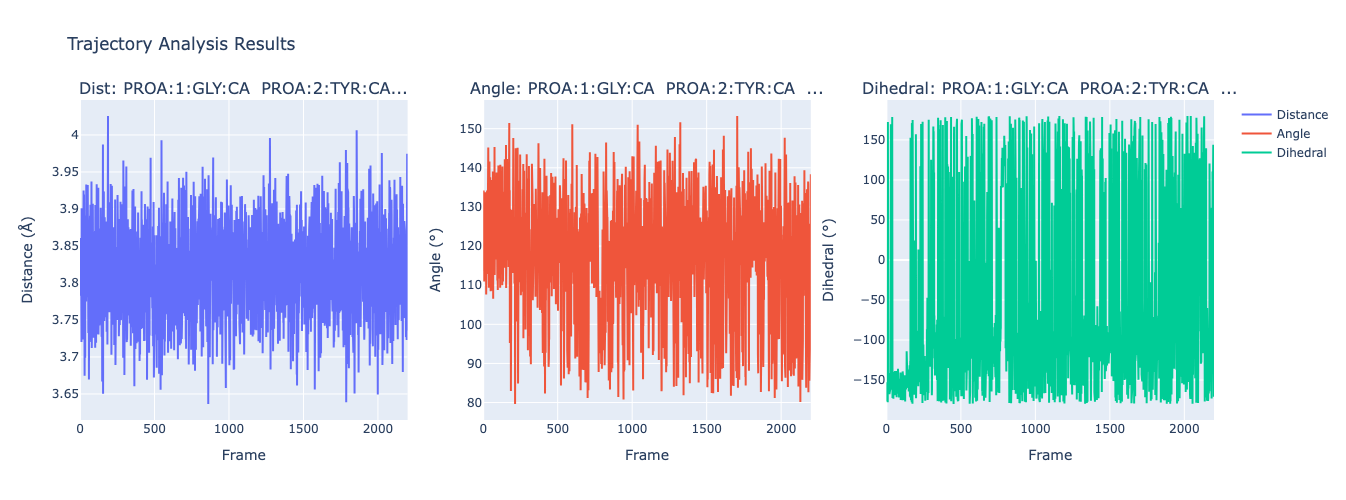

Plotly plots for trj_analysis generated.


In [16]:
# Create subplots using plotly
fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(f"Dist: {distances_def[0][:30]}...",
                                  f"Angle: {angles_def[0][:30]}...",
                                  f"Dihedral: {torsions_def[0][:30]}..."))

# Add traces
fig.add_trace(go.Scatter(x=time_axis, y=analysis_results.distance[:, 0], name="Distance"), row=1, col=1)
fig.add_trace(go.Scatter(x=time_axis, y=analysis_results.angle[:, 0], name="Angle"), row=1, col=2)
fig.add_trace(go.Scatter(x=time_axis, y=analysis_results.torsion[:, 0], name="Dihedral"), row=1, col=3)

# Update layout
fig.update_layout(height=500, width=1200, showlegend=True,
                 title_text="Trajectory Analysis Results")
fig.update_xaxes(title_text="Frame", row=1, col=1)
fig.update_xaxes(title_text="Frame", row=1, col=2)
fig.update_xaxes(title_text="Frame", row=1, col=3)
fig.update_yaxes(title_text="Distance (Å)", row=1, col=1)
fig.update_yaxes(title_text="Angle (°)", row=1, col=2)
fig.update_yaxes(title_text="Dihedral (°)", row=1, col=3)

fig.show()
print("Plotly plots for trj_analysis generated.")

### 4.2. Radius of Gyration: `rg_analysis`

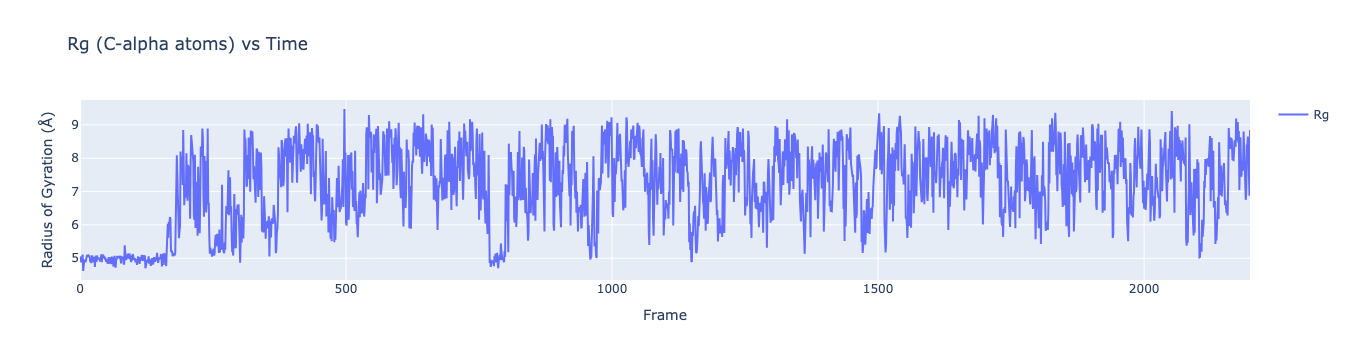

Plotly plot for rg_analysis generated.


In [17]:
rg_result = genesis_exe.rg_analysis(molecule=mol, trajs=traj, 
                                    selection_group=["an:CA"], 
                                    mass_weighted=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(traj.nframe), y=rg_result.rg,
                        mode='lines', name='Rg'))

fig.update_layout(
    title="Rg (C-alpha atoms) vs Time",
    xaxis_title="Frame",
    yaxis_title="Radius of Gyration (Å)",
    showlegend=True
)

fig.show()
print("Plotly plot for rg_analysis generated.")

### 4.3. RMSD `rmsd_analysis`

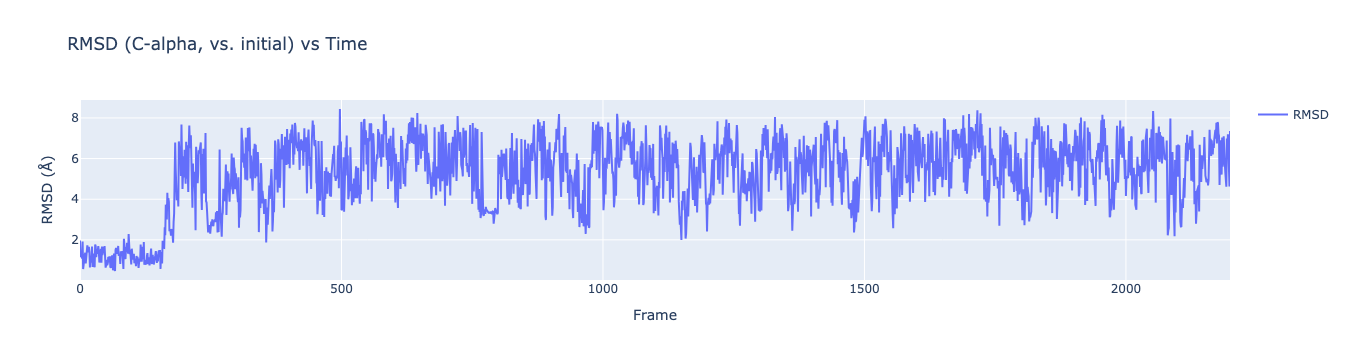

Plotly plot for rmsd_analysis generated.


In [18]:
rmsd_result = genesis_exe.rmsd_analysis(molecule=mol, trajs=traj, 
                                        selection_group=["an:CA"], 
                                        fitting_method="TR+ROT", 
                                        fitting_atom=1, analysis_atom=1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(traj.nframe), y=rmsd_result.rmsd,
                        mode='lines', name='RMSD'))

fig.update_layout(
    title="RMSD (C-alpha, vs. initial) vs Time",
    xaxis_title="Frame",
    yaxis_title="RMSD (Å)",
    showlegend=True
)

fig.show()
print("Plotly plot for rmsd_analysis generated.")

### 4.4. dRMSD `drms_analysis`

### 4.5. Average Structure `avecrd_analysis`

In [19]:
avecrd_result =  genesis_exe.avecrd_analysis(
                    mol, traj,
                    selection_group = ["segid:PROA and heavy", ],
                    fitting_method = "TR+ROT",
                    fitting_atom = 1,
                    check_only = False,
                    num_iterations = 5,
                    analysis_atom  = 1,
                    )

average_pdb_string = avecrd_result.pdb
print(f"\nAverage structure PDB generated (first 200 chars):\n{average_pdb_string[:200]}...")


Average structure PDB generated (first 200 chars):
MODEL        0
ATOM      1  N   GLY     1       1.552   8.785  -4.303  1.00  0.00      PROA
ATOM      2  CA  GLY     1       1.669   8.474  -4.277  1.00  0.00      PROA
ATOM      3  C   GLY     1     ...


In [20]:
AVERAGE_PDB_PATH_PY3DMOL = pathlib.Path("average_protein_py3dmol.pdb") 
with open(AVERAGE_PDB_PATH_PY3DMOL, "w") as f:
    f.write(average_pdb_string)
    print(f"Average structure saved to {AVERAGE_PDB_PATH_PY3DMOL}")
    view_avg_py3d = py3Dmol.view(width=600, height=400)
    view_avg_py3d.addModel(average_pdb_string, 'pdb');
    view_avg_py3d.setStyle({'cartoon': {'colorscheme': 'ssJmol'}});
    view_avg_py3d.zoomTo()
    print("py3Dmol visualization of average structure (run in Jupyter):")
    view_avg_py3d.show()

Average structure saved to average_protein_py3dmol.pdb
py3Dmol visualization of average structure (run in Jupyter):


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 5.1. Mean Square Displacement (MSD) and Diffusion Coefficient

In [21]:
msd_result = genesis_exe.msd_analysis(molecule=mol, trajs=traj, 
                                    selection_group=["an:CA"], 
                                    oversample=True, 
                                    delta=traj.nframe -1)

msd_data = msd_result.msd 

print(f"\nMSD data shape: {msd_data.shape}")
time_lags_ps = np.arange(1, msd_data.shape[0] + 1) * 1.0 

fig = go.Figure()
fig.add_trace(go.Scatter(x=time_lags_ps, y=msd_data[:,0],
                        mode='lines', name='MSD'))

fig.update_layout(
    title="MSD vs Time Lag (CA)",
    xaxis_title="Time Lag (ps)",
    yaxis_title="MSD (Å²)",
    showlegend=True
)

fig.show()
print("Plotly plot for MSD generated.")

diffusion_coeffs = genesis_exe.diffusion_analysis(msd_data=msd_data, time_step=1.0, start="20%")

print(f"\nDiffusion Coefficients (Å²/ps) and Intercepts:\n{diffusion_coeffs}")


MSD data shape: (2199, 1)


Plotly plot for MSD generated.

Diffusion Coefficients (Å²/ps) and Intercepts:
[[2.82615046e-30]
 [2.83110274e-30]
 [2.88442304e-30]
 ...
 [1.24402141e-30]
 [1.01627110e-30]
 [2.19652310e-31]]


In [22]:
os.makedirs("cv_wham_data", exist_ok=True);
num_cv_frames = 200
rows=np.arange(1, num_cv_frames +1)
values1 = np.random.normal(loc=1.0, scale=0.3, size=num_cv_frames)
data1 =  np.column_stack((rows, values1))

values2 = np.random.normal(loc=2.0, scale=0.3, size=num_cv_frames)
data2 =  np.column_stack((rows, values2))

values3 = np.random.normal(loc=3.0, scale=0.3, size=num_cv_frames)
data3 =  np.column_stack((rows, values3))

cv_file_template_wham = "cv_wham_data/window_{:d}.dat";

np.savetxt(cv_file_template_wham.format(1), data1, fmt="%d %.5f")
np.savetxt(cv_file_template_wham.format(2), data2, fmt="%d %.5f")
np.savetxt(cv_file_template_wham.format(3), data3, fmt="%d %.5f")

In [23]:
pmf_wham = genesis_exe.wham_analysis(cvfile=cv_file_template_wham, 
    dimension=1, nblocks=1, temperature=300.0, tolerance=1.0E-7, 
    rest_function=[1,], grids=[(0.0,4.0,81),], constant=[(30.0,30.0,30.0),], 
    reference=[(1.0,2.0,3.0),], is_periodic=[False])

In [24]:
os.makedirs("cv_mbar_data", exist_ok=True);
num_cv_frames = 200
rows=np.arange(1, num_cv_frames +1)
values1 = np.random.normal(loc=1.0, scale=0.3, size=num_cv_frames)
data1 =  np.column_stack((rows, values1))
values2 = np.random.normal(loc=2.0, scale=0.3, size=num_cv_frames)
data2 =  np.column_stack((rows, values2))
values3 = np.random.normal(loc=3.0, scale=0.3, size=num_cv_frames)
data3 =  np.column_stack((rows, values3))
cv_file_template_mbar = "cv_mbar_data/replica_{:d}.dat";
np.savetxt(cv_file_template_mbar.format(1), data1, fmt="%d %.5f")
np.savetxt(cv_file_template_mbar.format(2), data2, fmt="%d %.5f")
np.savetxt(cv_file_template_mbar.format(3), data3, fmt="%d %.5f")

In [25]:
# Run MBAR analysis
# Note: target_temperature is required for mbar_analysis
#fene_mbar = genesis_exe.mbar_analysis(
#    cvfile=cv_file_template_mbar, 
#    nreplica=3,
#    dimension=1, 
#    nblocks=1, 
#    temperature=300.0, 
#    target_temperature=300.0,  # Required parameter
#    tolerance=1.0E-7, 
#    rest_function=[1,], 
#    grids=[(0.0, 4.0, 81),], 
#    constant=[(30.0, 30.0, 30.0),], 
#    reference=[(1.0, 2.0, 3.0),], 
#    is_periodic=[False]
#)
#
#print(f"MBAR analysis completed.")
#print(f"Free energy result shape: {fene_mbar.shape}")

## 6. Interfacing with External MD Libraries

### 6.1. MDTraj

In [28]:
print("\nMDTraj imported.")
mdtraj_top = mol.to_mdtraj_topology()
print(f"SMolecule to MDTraj Topology: {mdtraj_top.n_atoms} atoms")
mdtraj_traj_obj = traj.to_mdtraj_trajectory(mol) 
print(f"STrajectories to MDTraj Trajectory: {mdtraj_traj_obj.n_frames} frames, {mdtraj_traj_obj.n_atoms} atoms")
#new_straj_mdt, new_smol_mdt = s_trajectories.STrajectories.from_mdtraj_trajectory(mdtraj_traj_obj)
#print(f"MDTraj Trajectory to STrajectories: {new_straj_mdt.nframe} frames, {new_straj_mdt.natom} atoms")
#new_straj_mdt.free() 


MDTraj imported.
SMolecule to MDTraj Topology: 138 atoms
STrajectories to MDTraj Trajectory: 2200 frames, 138 atoms


### 6.2 MDAnalysis

In [29]:
print("\nMDAnalysis imported.")
mda_universe_mol = mol.to_mdanalysis_universe()
print(f"SMolecule to MDAnalysis Universe (topology): {mda_universe_mol.atoms.n_atoms} atoms")
mda_universe_traj_obj = traj.to_mdanalysis_universe(mol) 
print(f"STrajectories to MDAnalysis Universe: {mda_universe_traj_obj.trajectory.n_frames} frames, {mda_universe_traj_obj.atoms.n_atoms} atoms")
#new_straj_mda, new_smol_mda = s_trajectories.STrajectories.from_mdanalysis_universe(mda_universe_traj_obj)
#print(f"MDAnalysis Universe to STrajectories: {new_straj_mda.nframe} frames, {new_straj_mda.natom} atoms")
#new_straj_mda.free()


MDAnalysis imported.
SMolecule to MDAnalysis Universe (topology): 138 atoms
STrajectories to MDAnalysis Universe: 2200 frames, 138 atoms


## 7. Interfacing with Scikit-learn

### 7.1. Feature Preparation

In [30]:
from sklearn.preprocessing import StandardScaler
print(f"\nScikit-learn imported for feature preparation.")

n_samples = traj.nframe
# Using C-alpha coordinates as features for dimensionality reduction
# Ensure your PDB/PSF allows selection of "name CA"
ca_indices = [i for i, name_array in enumerate(mol.atom_name) if ''.join(name_array).strip() == "CA"]
if not ca_indices: # Fallback if no CA atoms found (e.g. very small dummy molecule)
    print("Warning: No CA atoms found for Scikit-learn features. Using all atoms.")
    features_coords = traj.coords.reshape(n_samples, -1).astype(np.float32)
else:
    features_coords = traj.coords[:, ca_indices, :].reshape(n_samples, -1).astype(np.float32)

print(f"Shape of (CA) coordinate features: {features_coords.shape}")
scaler = StandardScaler()
scaled_features_coords = scaler.fit_transform(features_coords)
print(f"Shape of scaled (CA) coordinate features: {scaled_features_coords.shape}")


Scikit-learn imported for feature preparation.
Shape of (CA) coordinate features: (2200, 30)
Shape of scaled (CA) coordinate features: (2200, 30)


### 7.2. t-SNE Dimensionality Reduction

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

divide by zero encountered in matmul

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

overflow encountered in matmul

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning:

invalid value encountered in matmul

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

divide by zero encountered in matmul

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

overflow encountered in matmul

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning:

invalid value encountered in matmul

/Users/yasu/tmp/genesis/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:355: RuntimeWarning:

divide by zero encountered in matmul

/Users


t-SNE with Scikit-learn (on CA coordinates):
Shape of t-SNE embedding: (2200, 2)


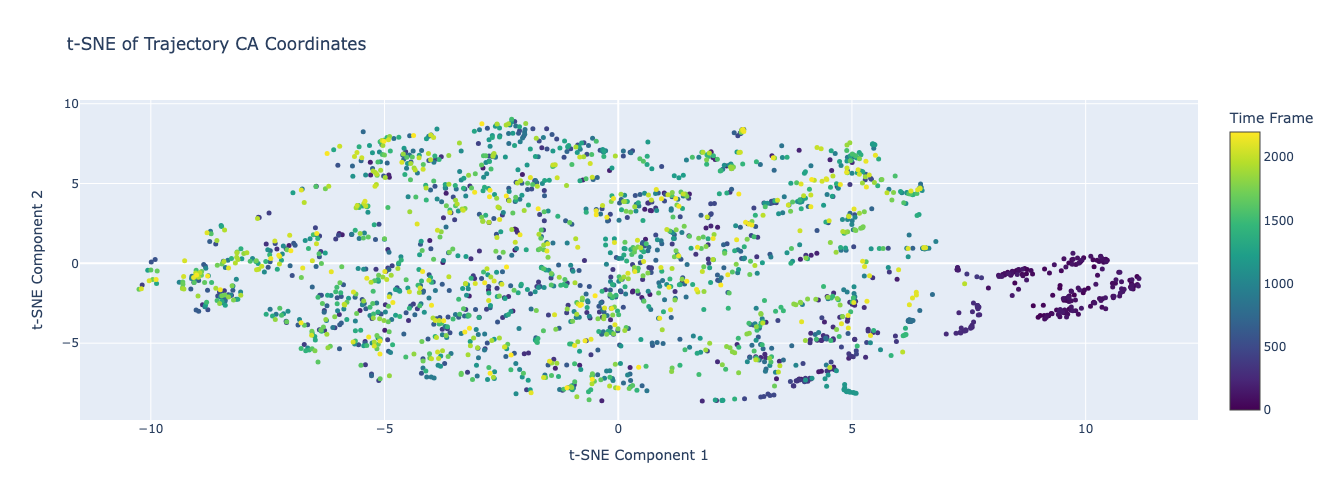

Plotly plot for t-SNE generated.


In [31]:
from sklearn.manifold import TSNE
import plotly.express as px

# Reduce dimensionality to 2 components using t-SNE
# n_samples should be greater than perplexity; adjust perplexity if needed for small N.
perplexity_val = min(30.0, float(n_samples - 1)) if n_samples > 1 else 5.0
if n_samples <= 1 : print("Warning: t-SNE requires multiple samples. Using dummy embedding if n_samples <=1")

tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, max_iter=300, init='pca', learning_rate='auto')
if n_samples > 1 and scaled_features_coords.shape[0] > 0:
    tsne_embedding = tsne.fit_transform(scaled_features_coords)
    print(f"\nt-SNE with Scikit-learn (on CA coordinates):")
    print(f"Shape of t-SNE embedding: {tsne_embedding.shape}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=tsne_embedding[:, 0],
        y=tsne_embedding[:, 1],
        mode='markers',
        marker=dict(
            size=5,  # Reduced marker size
            color=np.arange(traj.nframe),
            colorscale='Viridis',  # より時系列の変化がわかりやすいカラースケール
            showscale=True,
            colorbar=dict(title="Time Frame")  # Added colorbar title
        ),
        text=[f'Frame {i}' for i in range(traj.nframe)]
    ))

    fig.update_layout(
        title="t-SNE of Trajectory CA Coordinates",
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        showlegend=False,
        width=600,  # Adjusted width for a more square aspect ratio
        height=500  # Adjusted height for a more square aspect ratio
    )

    fig.show()
    print("Plotly plot for t-SNE generated.")
else:
    tsne_embedding = np.random.rand(n_samples, 2) # Dummy for plotting if no data
    print("Skipping t-SNE calculation due to insufficient samples or features.")

### 7.3. DBSCAN Clustering

HDBSCAN parameters: min_cluster_size=110, min_samples=22

HDBSCAN Clustering (on t-SNE embedding):
Estimated number of clusters: 6
Estimated number of noise points: 636
Cluster labels for first 10 frames: [0 0 0 0 0 0 0 0 0 0]


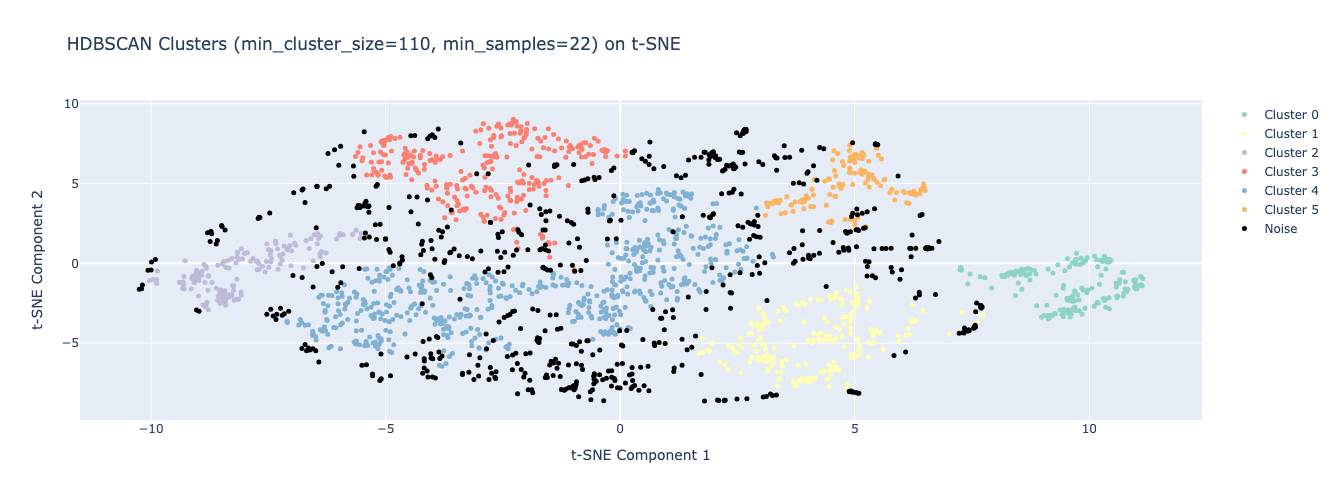

Plotly plot for HDBSCAN on t-SNE generated.


In [32]:
from sklearn.cluster import HDBSCAN
import plotly.express as px

# Apply HDBSCAN on the t-SNE embedded data or directly on scaled_features_coords
if tsne_embedding is not None and tsne_embedding.shape[0] > 0:
    # Set HDBSCAN parameters
    min_cluster_size = max(5, int(n_samples * 0.05))  # At least 5 samples or 5% of total samples
    min_samples = max(1, int(n_samples * 0.01))  # At least 1 sample or 1% of total samples

    print(f"HDBSCAN parameters: min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    cluster_labels_hdbscan = hdbscan.fit_predict(tsne_embedding)
    
    n_clusters_ = len(set(cluster_labels_hdbscan)) - (1 if -1 in cluster_labels_hdbscan else 0)
    n_noise_ = list(cluster_labels_hdbscan).count(-1)

    print(f"\nHDBSCAN Clustering (on t-SNE embedding):")
    print(f"Estimated number of clusters: {n_clusters_}")
    print(f"Estimated number of noise points: {n_noise_}")
    print(f"Cluster labels for first 10 frames: {cluster_labels_hdbscan[:10]}")

    # Create a color map for clusters
    colors = px.colors.qualitative.Set3
    if n_clusters_ > len(colors):
        colors = px.colors.qualitative.Set3 * (n_clusters_ // len(colors) + 1)

    fig = go.Figure()
    
    # Plot each cluster
    for k in range(n_clusters_):
        mask = cluster_labels_hdbscan == k
        cluster_indices = np.where(mask)[0]
        fig.add_trace(go.Scatter(
            x=tsne_embedding[mask, 0],
            y=tsne_embedding[mask, 1],
            mode='markers',
            name=f'Cluster {k}',
            marker=dict(
                size=5,
                color=colors[k % len(colors)]
            ),
            text=[f'Frame {i}, Cluster {k}' for i in cluster_indices],
            hovertemplate='<b>%{text}</b><br>x: %{x:.3f}<br>y: %{y:.3f}<extra></extra>'
        ))

    # Plot noise points if any
    if n_noise_ > 0:
        mask = cluster_labels_hdbscan == -1
        noise_indices = np.where(mask)[0]
        fig.add_trace(go.Scatter(
            x=tsne_embedding[mask, 0],
            y=tsne_embedding[mask, 1],
            mode='markers',
            name='Noise',
            marker=dict(
                size=5,
                color='black'
            ),
            text=[f'Frame {i}, Noise' for i in noise_indices],
            hovertemplate='<b>%{text}</b><br>x: %{x:.3f}<br>y: %{y:.3f}<extra></extra>'
        ))

    fig.update_layout(
        title=f"HDBSCAN Clusters (min_cluster_size={min_cluster_size}, min_samples={min_samples}) on t-SNE",
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        showlegend=True, 
        width=600,  # Adjusted width for a more square aspect ratio
        height=500  # Adjusted height for a more square aspect ratio
    )

    fig.show()
    print("Plotly plot for HDBSCAN on t-SNE generated.")
else:
    print("\nSkipping HDBSCAN: t-SNE embedding not available.")

## 8. Interfacing with PyTorch: Variational Autoencoder (VAE)

### 8.1. Data Preparation for PyTorch

In [33]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
print(f"\nPyTorch version {torch.__version__} imported.")

print(f"\nUsing trajectory with {traj.nframe} frames and {traj.natom} atoms for PyTorch Autoencoder.")
# Use scaled CA coordinates as input for the autoencoder
if 'scaled_features_coords' in globals() and scaled_features_coords is not None:
    pytorch_input_features = torch.tensor(scaled_features_coords, dtype=torch.float32)
    print(f"Shape of PyTorch input tensor (scaled CA coordinates): {pytorch_input_features.shape}")

    # For an autoencoder, the target is the same as the input
    pytorch_target_outputs = pytorch_input_features.clone() 
    print(f"Shape of PyTorch target tensor (same as input): {pytorch_target_outputs.shape}")

    dataset_torch_ae = TensorDataset(pytorch_input_features, pytorch_target_outputs)
    batch_size_torch_ae = min(4, len(dataset_torch_ae)) if len(dataset_torch_ae) > 0 else 1
    dataloader_torch_ae = DataLoader(dataset_torch_ae, batch_size=batch_size_torch_ae, shuffle=True) if len(dataset_torch_ae) > 0 else None
    if dataloader_torch_ae: print(f"Created PyTorch DataLoader for Autoencoder with batch size {batch_size_torch_ae}")
    else: print("Could not create DataLoader for Autoencoder.")
else:
    print("Scaled features not available. Skipping PyTorch Autoencoder data preparation.")
    dataloader_torch_ae = None


PyTorch version 2.7.1 imported.

Using trajectory with 2200 frames and 138 atoms for PyTorch Autoencoder.
Shape of PyTorch input tensor (scaled CA coordinates): torch.Size([2200, 30])
Shape of PyTorch target tensor (same as input): torch.Size([2200, 30])
Created PyTorch DataLoader for Autoencoder with batch size 4


### 8.2. Variational Autoencoder

In [34]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.datasets import load_digits
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, in_dim=30, hidden_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, z_dim * 2)  # mean and variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Initialize the model, optimizer and loss function
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss(reduction='sum')

# Convert the data to a PyTorch tensor
from sklearn.preprocessing import StandardScaler

# 標準化を実行
scaler = StandardScaler()
normalized_features = scaler.fit_transform(pytorch_input_features.cpu().numpy())
data = torch.tensor(normalized_features, dtype=torch.float32).to(device)

# Training loop
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    recon, mu, logvar = model(data)
    loss = criterion(recon, data)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss += kl_divergence
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 83893.703125
Epoch: 1000, Loss: 60101.9765625
Epoch: 2000, Loss: 57087.2109375
Epoch: 3000, Loss: 56212.33203125
Epoch: 4000, Loss: 55723.7421875
Epoch: 5000, Loss: 55574.73828125
Epoch: 6000, Loss: 55436.83203125
Epoch: 7000, Loss: 55396.5234375
Epoch: 8000, Loss: 55305.01953125
Epoch: 9000, Loss: 55249.09375


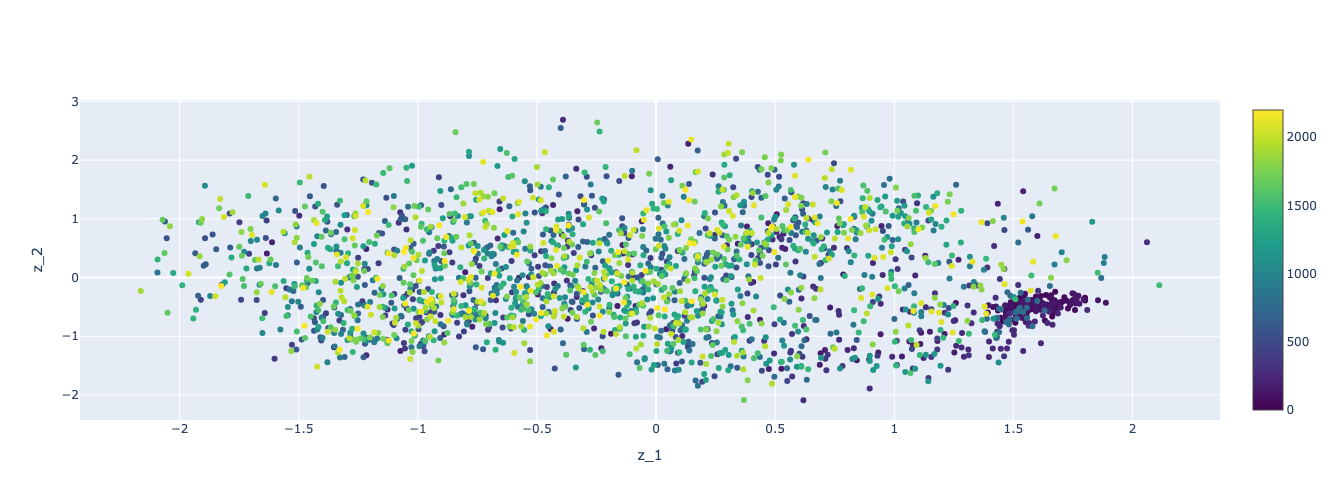

In [35]:
import plotly.graph_objects as go
import numpy as np

# Visualize the 2-D latent space (Plotly)
model.eval()
with torch.no_grad():
    _, mu, _ = model(data)
mu = mu.cpu().numpy()

fig = go.Figure(
    data=go.Scatter(
        x=mu[:, 0],
        y=mu[:, 1],
        mode="markers",
        marker=dict(
            color=np.arange(len(mu)),   # per-point colouring
            colorscale="Viridis",
            showscale=True              # colour bar
        )
    )
)

fig.update_layout(
    width=600, height=500,
    xaxis_title="z_1",
    yaxis_title="z_2"
)

fig.show()
